In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib inline


# RSM2310 - Fixed income securities
This notebook covers interpolation,bootstrapping,interpolation using Nelson Siegel model.

## Load data and pre process:
The csv file data.csv contains the historical rates for a set of trasury bonds.

In [123]:
def load_data():
    data = pd.read_csv('data.csv')
    data = data.set_index('Time Period')

    #NDs=[]
    #count =0
    #for i in data.index:
    #    if 'ND'== data.loc[i][1]:
    #        NDs.append(i)
    #        count += 1
        
    
    #print("Excluded {} NDs".format(count))
    #print("{}% of the total".format(100*round(count/data.shape[0],2)))
    data_ = data.dropna()
    data_ = data.applymap(f).copy()
    data_ = data_[data_['RIFLGFCM06_N.B']>0] # keeping only data with at least one strip
    data_ = data_.loc['7/31/2001':]
    return data,data_

In [124]:
def f(x):
    try:
        return float(x)/100
    except:
        return np.nan

In [125]:
data,data_ = load_data()

Plot of the rates from 2001 - 2018

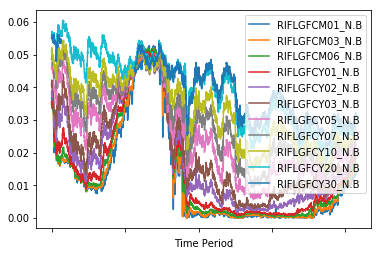

In [5]:
data_.plot();

### Most rescent yield curve:

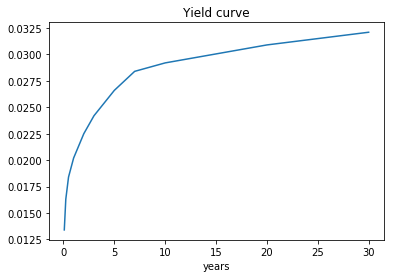

In [6]:
available_Ts = np.array([1/12,3/13,6/12,1,2,3,5,7,10,20,30])
plt.title('Yield curve')
plt.xlabel('years')
plt.plot(available_Ts,data_[-1:].as_matrix().flatten())

Fill the gaps to bootstrap:
-  using spline
-  using NS

# Cubic spline

In [7]:
from scipy.interpolate import CubicSpline
def spline(x_,x,y):   
    cs = CubicSpline(x,y)
    y_ = np.append(y[:3],cs(x_))
    return y

Running a test, interpolate missing rates to perform bootstrapping;

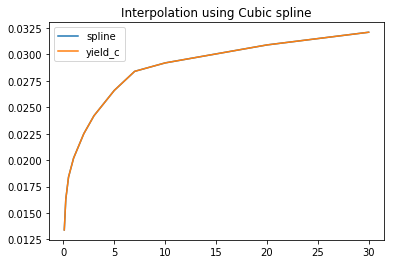

In [8]:
x = available_Ts
y = data_[-1:].as_matrix().flatten()

cf = 2 #coupon frequency
x_ = np.append(x[:3],np.arange(1,30+1/2,1/2))

y_ = spline(x_,x,y)

plt.title('Interpolation using Cubic spline');
plt.plot(x,y_,label='spline');
plt.plot(x,y,label='yield_c');
plt.legend();


# Nelson Siegel

The Nelon Siegel model follow the equation:

\begin{equation}
R(0,t) = \beta_0 + \beta_1 \frac{1-e^{(\frac{-t}{T})}}{t/T} + \beta_2  (\frac{1-e^{(\frac{-t}{T})}}{t/T} -e^{\frac{-t}{T}})
\end{equation}

Where:

-  $R(0,t)$: pure discount rate with maturity t
-  $\beta_0$: level parameter, the long term rate
-  $\beta_1$: slope parameter, the spread short/long-term
-  $\beta_2$: curvature parameter
-  $T$: scale parameter



In [72]:
class NelsonSiegel():
    
    def __init__(self,x_,x,y):
        self.x = x
        self.y = y
        self.x_ = x_
          
    def loss(self,w):
        t = self.x
        A = [np.ones(t.shape[0]),(1-np.exp(-t/w[3]))/(t/w[3]),(1-np.exp(-t/w[3]))/(t/w[3])-np.exp(-t/w[3])]
        Ax = w[:3].dot(A)
        error = self.y-Ax
        return np.sum(error**2)
    
    def get_w(self):
        y = self.y  
        if np.sum(y)==0:
            print('gotcha')
        x0 = [y[-1],np.abs(y[0]-y[1]),y[0],y[-1]]
        self.opt_results = optimize.minimize(self.loss,x0=x0,jac=False,tol=1e-13,method='BFGS')
        self.w = self.opt_results.x
        
    def NS(self):
        self.get_w()
        y = self.y
        w = self.w
        t = self.x_
        A = [np.ones(t.shape[0]),(1-np.exp(-t/w[3]))/(t/w[3]),(1-np.exp(-t/w[3]))/(t/w[3])-np.exp(-t/w[3])]
        return np.append(self.y[:3],w[:3].dot(A))  

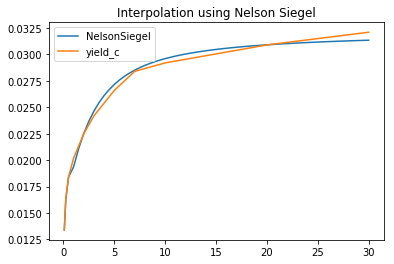

In [73]:
x = available_Ts
y = data_[-1:].as_matrix().flatten()

cf = 2 #coupon frequency
x_ = np.arange(1,30+1/2,1/2)

ns = NelsonSiegel(x_,x,y)
y_ = ns.NS()

x_ = np.append(x[:3],np.arange(1,30+1/2,1/2))

plt.title('Interpolation using Nelson Siegel');
plt.plot(x_,y_,label='NelsonSiegel');
plt.plot(x,y,label='yield_c');
plt.legend();


# Interpolation for Bootstraping
Because we will be using both, lets wrap these functions in one class called interpol:

In [161]:
class interpolation(): 
        
    def solve(self,y,x_=None,x=None,method='spline',plot=0):
        x = np.array([1/12,3/13,6/12,1,2,3,5,7,10,20,30])
        x_ = np.arange(1,30+1/2,1/2)

        if method == 'spline':
            y_ = spline(x_,x,y)
            x_ = np.append(x[:3],np.arange(1,30+1/2,1/2))
            if plot==1:
                plt.title('Interpolation using Cubic spline');
                plt.plot(x,y_,label='spline');
                plt.plot(x,y,label='yield_c');
                plt.legend();
            
            
        elif method == 'NelsonSiegel':
            ns = NelsonSiegel(x_,x,y)
            y_ = ns.NS()
            x_ = np.append(x[:3],np.arange(1,30+1/2,1/2))
            if plot==1:
                plt.title('Interpolation using Nelson Siegel');
                plt.plot(x_,y_,label='NelsonSiegel');
                plt.plot(x,y,label='yield_c');
                plt.legend();
            self.coef.append(ns.w)    
        return y_
            
    def spline(x_,x,y):   
        cs = CubicSpline(x,y)
        self.coef.append(cs)
        y_ = np.append(y[:3],cs(x_))
        return y_

Ok, now we have an interpolation class to test. The assumption is that these classes will be used to interpolate data with maturities np.arange(1,30+1/2,1/2) and that the first tree data points in y are strip rates, thus they are added to the output vector.

Now, lets try bootstrapping data:

# Bootstrapping 
Here we will vectorize the Bootstrapping procedure in order to make ir more computationally efficient:

In [16]:
#single variable
def bootstrap(x,y):
    N = len(x)
    powers = np.arange(1,N+1)
    ys = np.tile(y,(N,1)).T
    f = 100
    F = f*np.diag(np.ones(N))
    c = y*f/2
    C = ys*f/2
    YS = 1/np.power(ys+1,powers)
    b = np.sum(np.tril((C+F)*YS),axis=1)
    A = np.tril(F + C)
    rates = np.linalg.solve(A,b)
    rates[rates>0]=np.power(1/rates[rates>0],1/powers)
    
    return rates - 1


In [17]:
bootstrap(x,y)

array([0.0134    , 0.01631195, 0.0184288 , 0.02025212, 0.02260128,
       0.02434678, 0.02684464, 0.02873183, 0.02956087, 0.03138658,
       0.0326819 ])

Great, now using the same vectorized approach we can expand the function to deal with bootstraping n cross sectional data at a time by using 3d array structures.

In [167]:
#multivariable
def BootStrap(x,y):
    N = len(x)
    n = y.shape[0]
    powers = np.arange(1,N+1)
    ys = np.tile(y,(1,N,1))
    ys = np.swapaxes(ys,2,1)
    f = 100
    F = np.tile(f*np.diag(np.ones(N)),(n,1,1))
    C = ys*f/2
    YS = 1/np.power(ys+1,powers)
    b = np.sum(np.tril((C+F)*YS),axis=2)
    A = np.tril(F + C)
    rates = np.linalg.solve(A,b)
    
    return np.power(1/rates,1/powers) -1
        

In [168]:
x = available_Ts
n=100
y = data_[-n:].as_matrix().reshape(n,1,data_.shape[1])

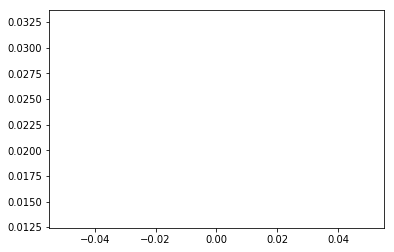

In [169]:
r = BootStrap(x,y)
plt.plot(r);

# TermStructure class:
This class will wrap the other operations

In [162]:
class TermStructure(interpolation):
    def __init__(self,data,method='spline'):
        self.data = data
        self.method = method
        self.coef = []
        
    def get_strip(self): 
        y = self.data  
        y=y[y!=y.isnull()]
        
        self.index = y.index
        x = np.array([1/12,3/13,6/12,1,2,3,5,7,10,20,30])
        x_ = np.arange(1,30+1/2,1/2)
        
        a = y.apply(self.solve,method=self.method,axis=1)

        if a.shape[0]==1:
            self.r = bootstrap(x,y)        
        else:
            a = a.as_matrix().reshape(a.shape[0],1,a.shape[1])
            self.r = BootStrap(x,a)   
        return self.r

In [163]:
y = data_[-500:]
TS = TermStructure(y,method='spline')

In [164]:
r = TS.get_strip()

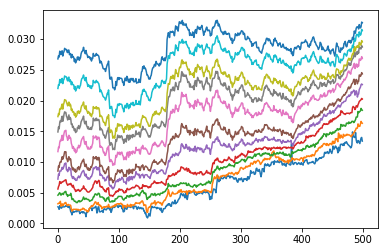

In [165]:
plt.plot(r);

In [166]:
TS.coef

[]

In [96]:
y.loc['4/24/2014']

RIFLGFCM01_N.B    0.0000
RIFLGFCM03_N.B    0.0001
RIFLGFCM06_N.B    0.0004
RIFLGFCY01_N.B    0.0010
RIFLGFCY02_N.B    0.0043
RIFLGFCY03_N.B    0.0091
RIFLGFCY05_N.B    0.0174
RIFLGFCY07_N.B    0.0230
RIFLGFCY10_N.B    0.0270
RIFLGFCY20_N.B    0.0322
RIFLGFCY30_N.B    0.0346
Name: 4/24/2014, dtype: float64